In [14]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

### Reading in C. Elegans AnnData

In [17]:
# From the scanpy module.
adata = sc.read_h5ad("ad_worm_aging.h5ad")

# Part of the data matrix.
adata.obs

,n_counts,n_genes,timepoint,annotate_name
TCTTGCGAGTCCTGCG-1-TC2_d11_1,53587.0,619,d11,41_2:marginal cells
GCTACAAGTGTGGTCC-1-TC2_d11_1,52800.0,253,d11,41_1:NA pharyngeal epithelium
TGGGAAGTCGGCTTGG-1-TC2_d11_1,43280.0,1459,d11,41_2:marginal cells
AAGTGAACAACCGACC-1-TC2_d11_1,31445.0,1140,d11,41_1:NA pharyngeal epithelium
GTAGCTAAGCTACGTT-1-TC2_d11_1,30088.0,1476,d11,78_0:pharyngeal gland cell
...,...,...,...,...
TCAGGTACAGACAATA-1-TC2_d8_2,283.0,190,d8,34_1:PH socket
CTGTAGACATTGCTGA-1-TC2_d8_2,315.0,221,d8,52_0:RMD motor neurons
CGTGATAGTACACTCA-1-TC2_d8_2,271.0,183,d8,3_0:germline
GTTCATTAGCGCCATC-1-TC2_d8_2,261.0,134,d8,7_0:vulval muscle


### Using an Autoencoder on Single-Cell Data (adata)
This code applies a simple Autoencoder to adata.X (the gene expression matrix) to perform dimensionality reduction and feature extraction. The Autoencoder compresses gene expression data into a lower-dimensional latent space and then reconstructs it.

In [19]:
# Define Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [21]:
# Convert `adata.X` to a dense NumPy array and then to a PyTorch tensor
adata_tensor = torch.tensor(adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X, dtype=torch.float32)

# Define model parameters
input_size = adata_tensor.shape[1]  # Number of genes
encoding_dim = 8  # Dimensionality of latent space

# Initialize model, loss function, and optimizer
model = Autoencoder(input_size, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Autoencoder
epochs = 50
batch_size = 128
for epoch in range(epochs):
    for i in range(0, adata_tensor.shape[0], batch_size):
        batch = adata_tensor[i:i + batch_size]
        optimizer.zero_grad()
        encoded, decoded = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Store the learned latent representations in `adata.obsm`
with torch.no_grad():
    latent_embeddings, _ = model(adata_tensor)

adata.obsm["X_autoencoder"] = latent_embeddings.numpy()

# Verify the new embeddings
print("New latent space shape:", adata.obsm["X_autoencoder"].shape)

Epoch [10/50], Loss: 0.0877
Epoch [20/50], Loss: 0.0853
Epoch [30/50], Loss: 0.0847
Epoch [40/50], Loss: 0.0845
Epoch [50/50], Loss: 0.0844
New latent space shape: (47423, 8)


### Compare Autoencoder Embeddings and PCA for UMAP Clustering

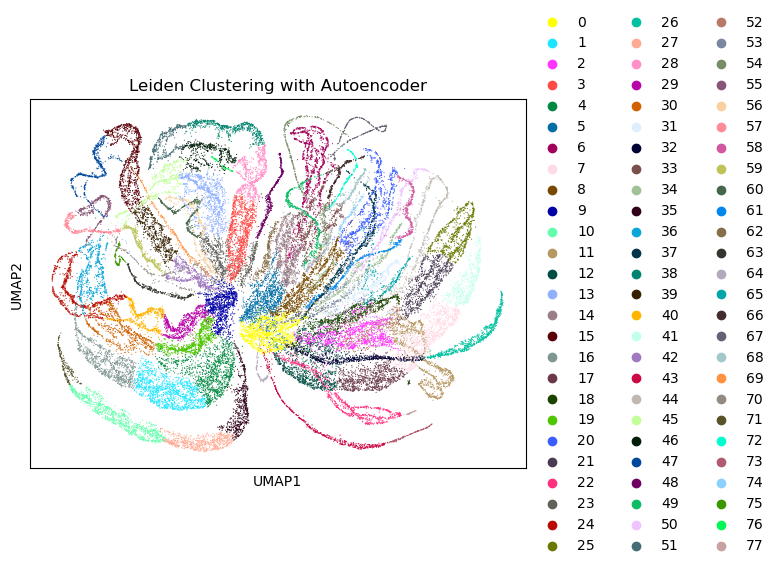

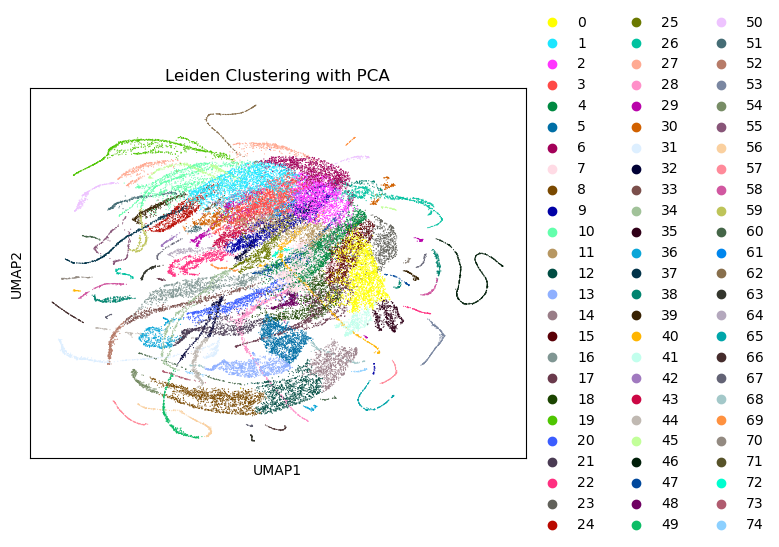

In [39]:
# Perform standard autoencoder clustering
sc.pp.neighbors(adata, use_rep="X_autoencoder")
sc.tl.leiden(adata, resolution=1)
sc.tl.umap(adata)

# Plot UMAP with Leiden clusters
sc.pl.umap(adata, color="leiden", title="Leiden Clustering with Autoencoder")

#-----------------------------------------------------------------------

# Perform standard PCA-based clustering
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.leiden(adata, resolution=1)
sc.tl.umap(adata)

# UMAP with PCA
sc.pl.umap(adata, color=["leiden"], title="Leiden Clustering with PCA")

### Key Observations
1. The Autoencoder UMAP appears more structured with curved, flower-like clusters, suggesting that the autoencoder captures non-linear gene expression relationships better than PCA. Moreover, the clusters appear tighter and more distinct, implying better feature extraction.
2. PCA Has More Overlapping and Spread-Out Clusters. This is expected because PCA is a linear method, which struggles to capture complex non-linear relationships in gene expression. Elongated and stretched clusters may indicate loss of information compared to the autoencoder.
3. In the Autoencoder UMAP, individual clusters are well-separated, indicating better cell-type discrimination.
4. If this dataset represents different cell types or states, the autoencoder clustering may provide a more biologically meaningful separation. In other words, the autoencoder's ability to model non-linear gene interactions may reveal hidden subpopulations that PCA might miss.
